# Explore the 'Dates' column

In this notebook, we're going to explore the **Dates** column, especially the reliability of each date columns. Then we'll try to come up with an idea which will improve our model's accuracy.

In [5]:
%matplotlib inline  

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Load Data

In [6]:
data = pd.read_csv("../data/train.csv")
data.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


## Feature Engineering

### Convert the **Dates** column to many numerical columns

In [7]:
from datetime import datetime

total_count = data.shape[0]
count = 0

dates_data = []

for index, row in data["Dates"].iteritems():
    count = count + 1

    if count % 100000 == 0:
        print("processing... {0}/{1}".format(count, total_count))

    date = datetime.strptime(row, "%Y-%m-%d %H:%M:%S")

    dates_data.append({
        "index": index,
        "Dates-Year": date.year,
        "Dates-Month": date.month,
        "Dates-Day": date.day,
        "Dates-Hour": date.hour,
        "Dates-Minute": date.minute,
        "Dates-Second": date.second,
    })
    
dates_dataframe = pd.DataFrame.from_dict(dates_data).astype('int32')
dates_dataframe = dates_dataframe.set_index("index")

dates_columns = ["Dates-Year", "Dates-Month", "Dates-Day", "Dates-Hour", "Dates-Minute", "Dates-Second"]
dates_dataframe = dates_dataframe[dates_columns]

# All "Dates-Second" variable is equal to zero. Therefore, we can remove it.
second_list = dates_dataframe["Dates-Second"].unique()
print("list of seconds = {0}".format(second_list))

dates_dataframe = dates_dataframe.drop("Dates-Second", axis=1)

data = pd.concat([data, dates_dataframe], axis=1)

data.head(3)

processing... 100000/878049
processing... 200000/878049
processing... 300000/878049
processing... 400000/878049
processing... 500000/878049
processing... 600000/878049
processing... 700000/878049
processing... 800000/878049
list of seconds = [0]


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Dates-Year,Dates-Month,Dates-Day,Dates-Hour,Dates-Minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33


## Explore

### Plot categories by Dates

In [82]:
import seaborn as sns

def format_category(index, value, total_count):
    return "{0}  {1} ({2:.3f}%)".format(index, value, value / total_count * 100)

def plot_by_category(data, column_name, color='r'):
    category_list = data["Category"].value_counts().index
    total_count = data.shape[0]

    f, axes = plt.subplots(10, 4, figsize=(24, 48))

    for i, category in enumerate(category_list):
        category_index = data[data["Category"] == category].index
        category_count = len(category_index)
        dates_values = data.loc[category_index, column_name]
        
        category_label = "{0}  {1} ({2:.3f}%)" \
                            .format(category, category_count, category_count / total_count * 100)

        ax = axes[i / 4, i % 4]

        x_list = dates_values.unique()
        bins = range(min(x_list), max(x_list) + 1, 1)

        sns.distplot(dates_values, axlabel=category_label, color=color, kde=False, bins=bins, ax=ax)

/Users/shaynekang/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


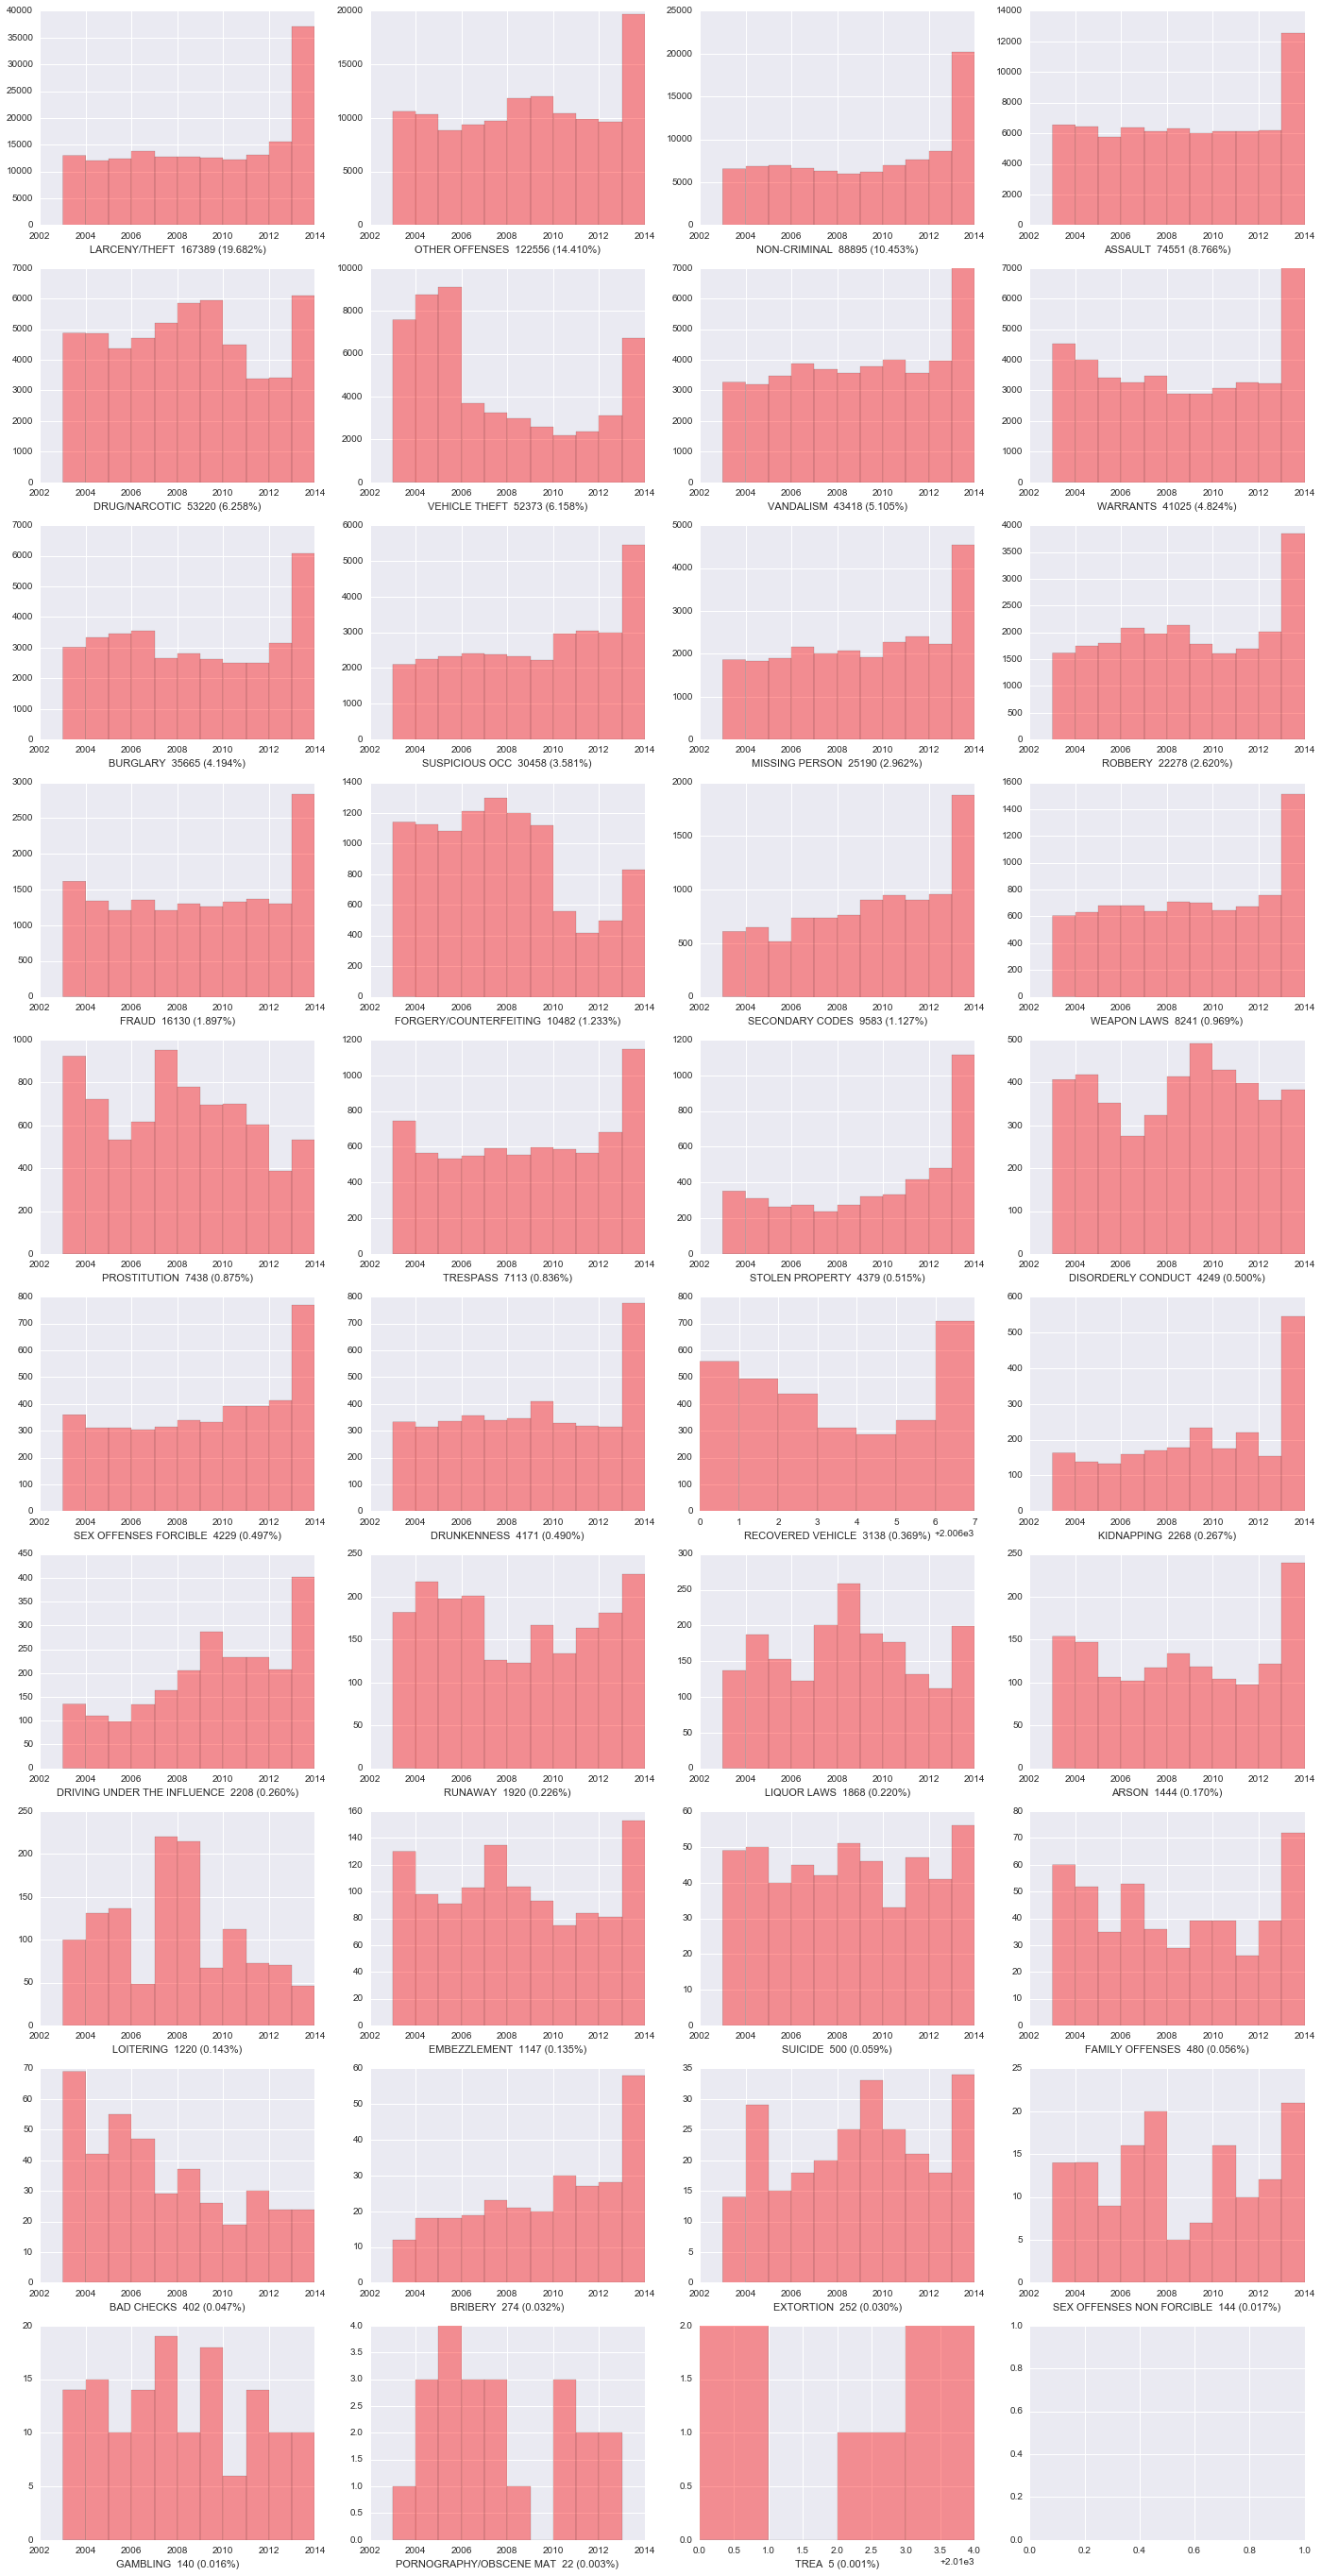

In [83]:
# Ignore 2015 due to it's relatively small dataset.
dates_except_2015 = data[data["Dates-Year"] < 2015]
plot_by_category(dates_except_2015, "Dates-Year", color='r')

/Users/shaynekang/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


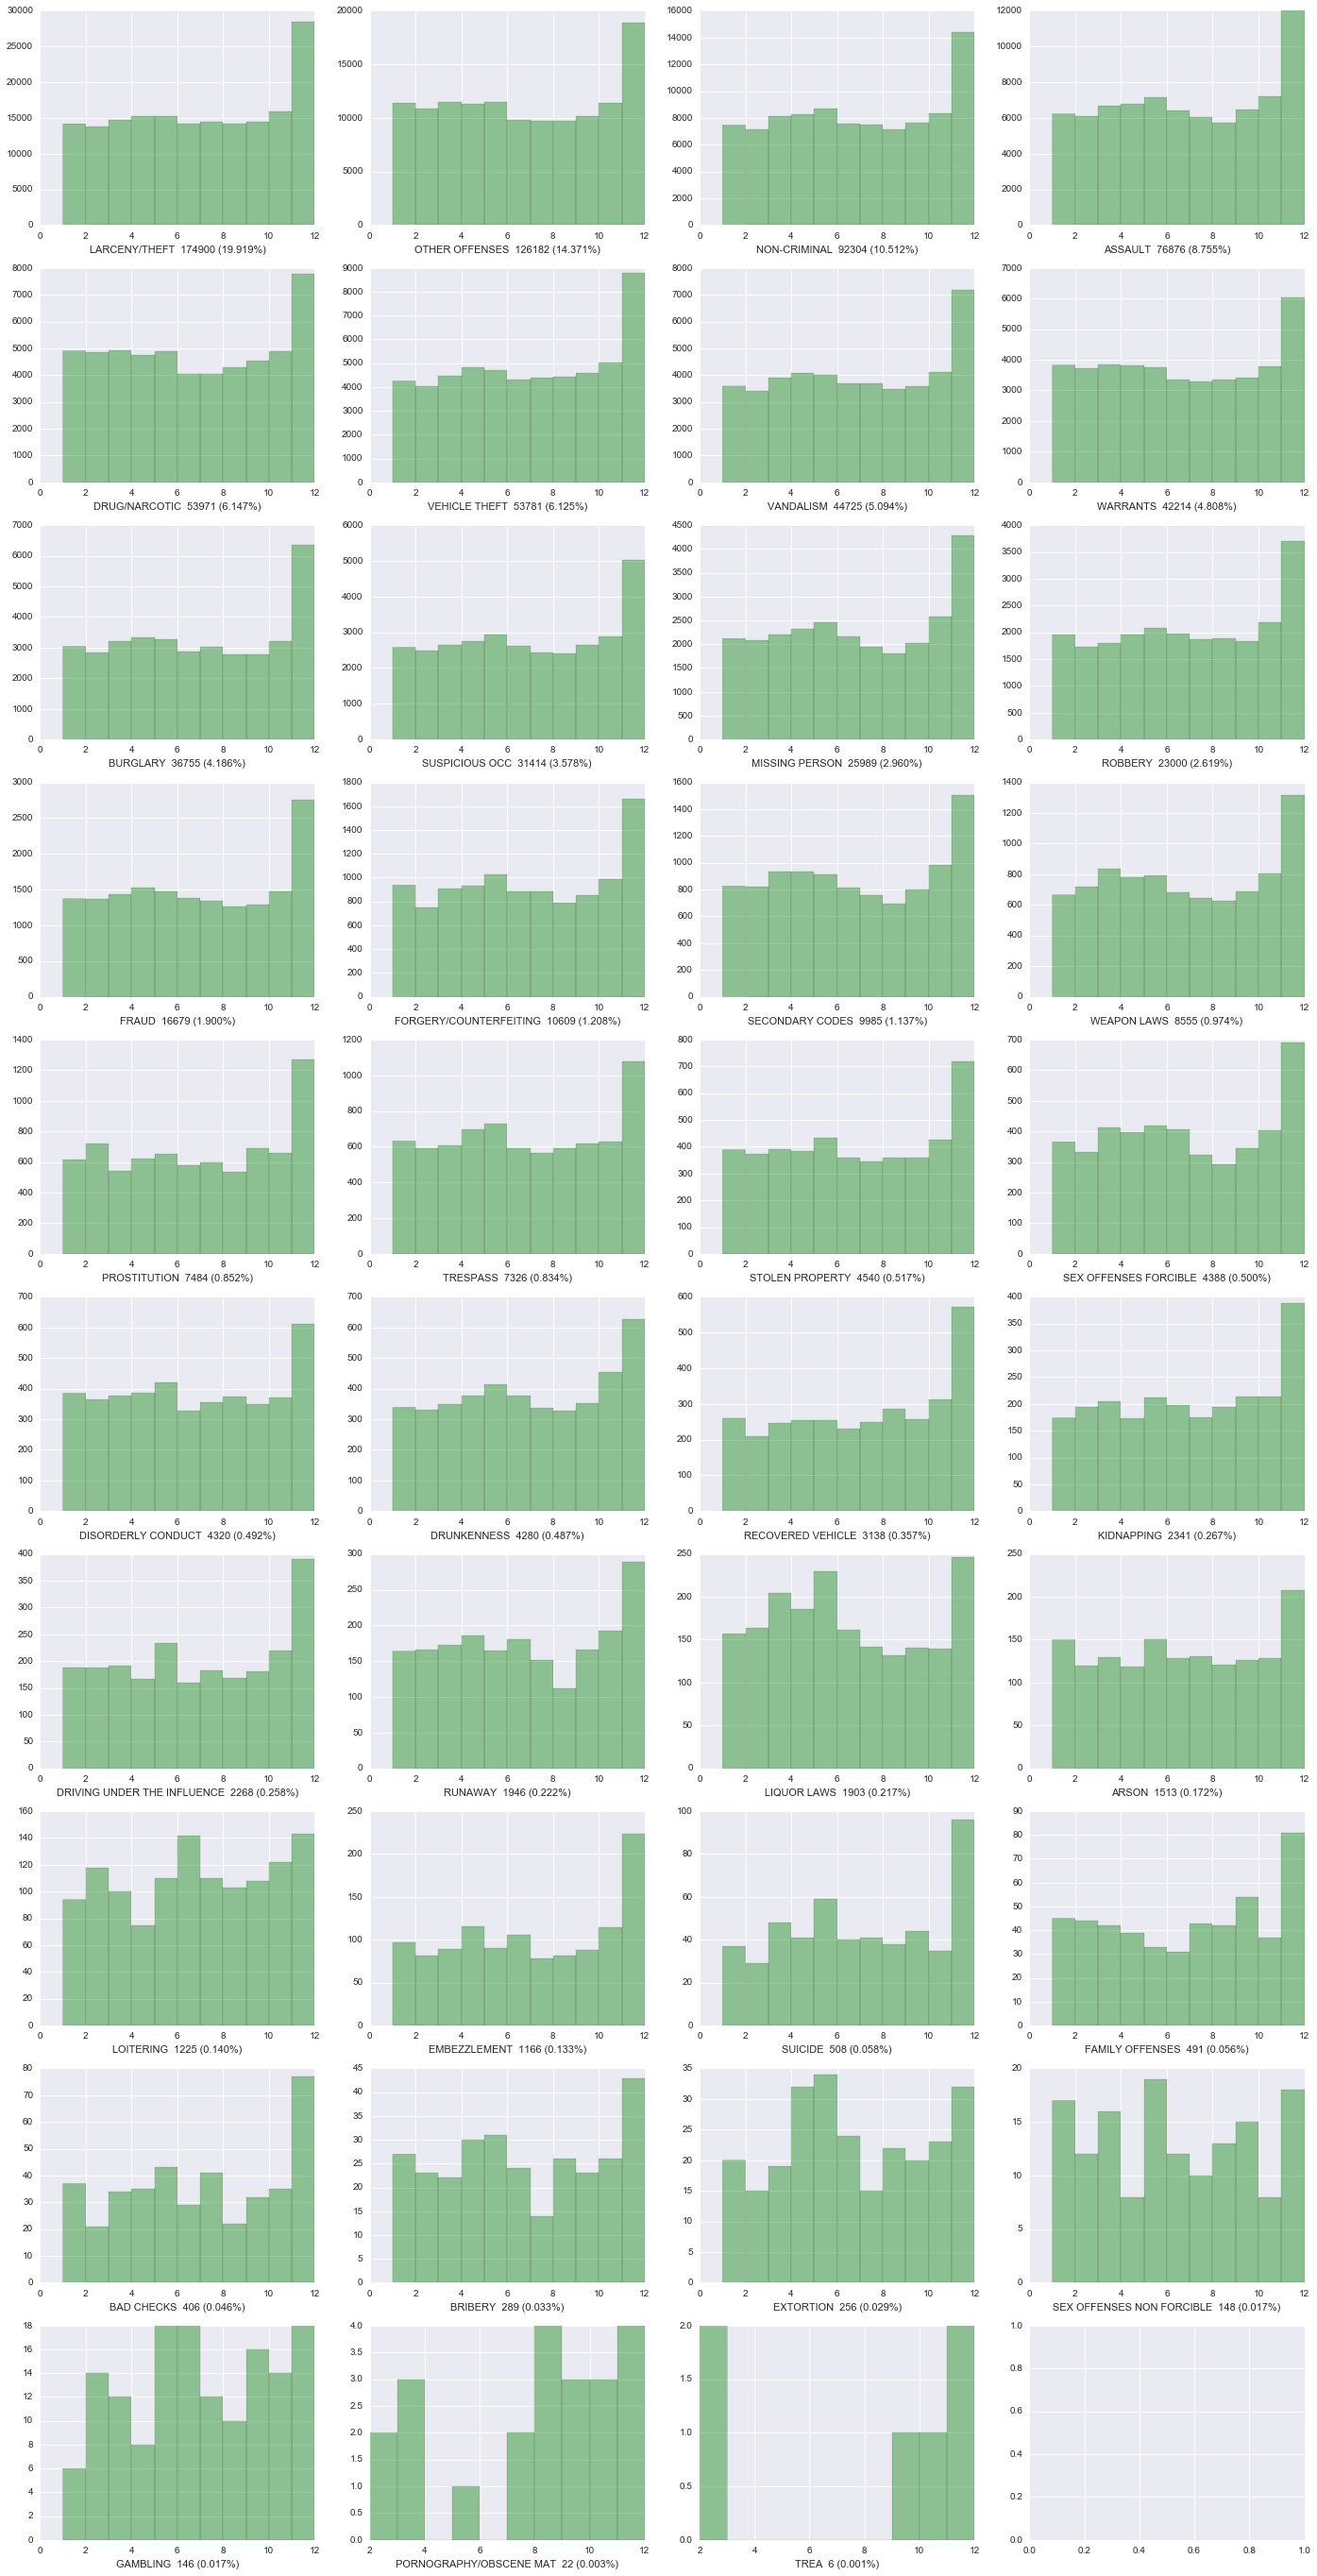

In [84]:
plot_by_category(data, "Dates-Month", color='g')

/Users/shaynekang/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


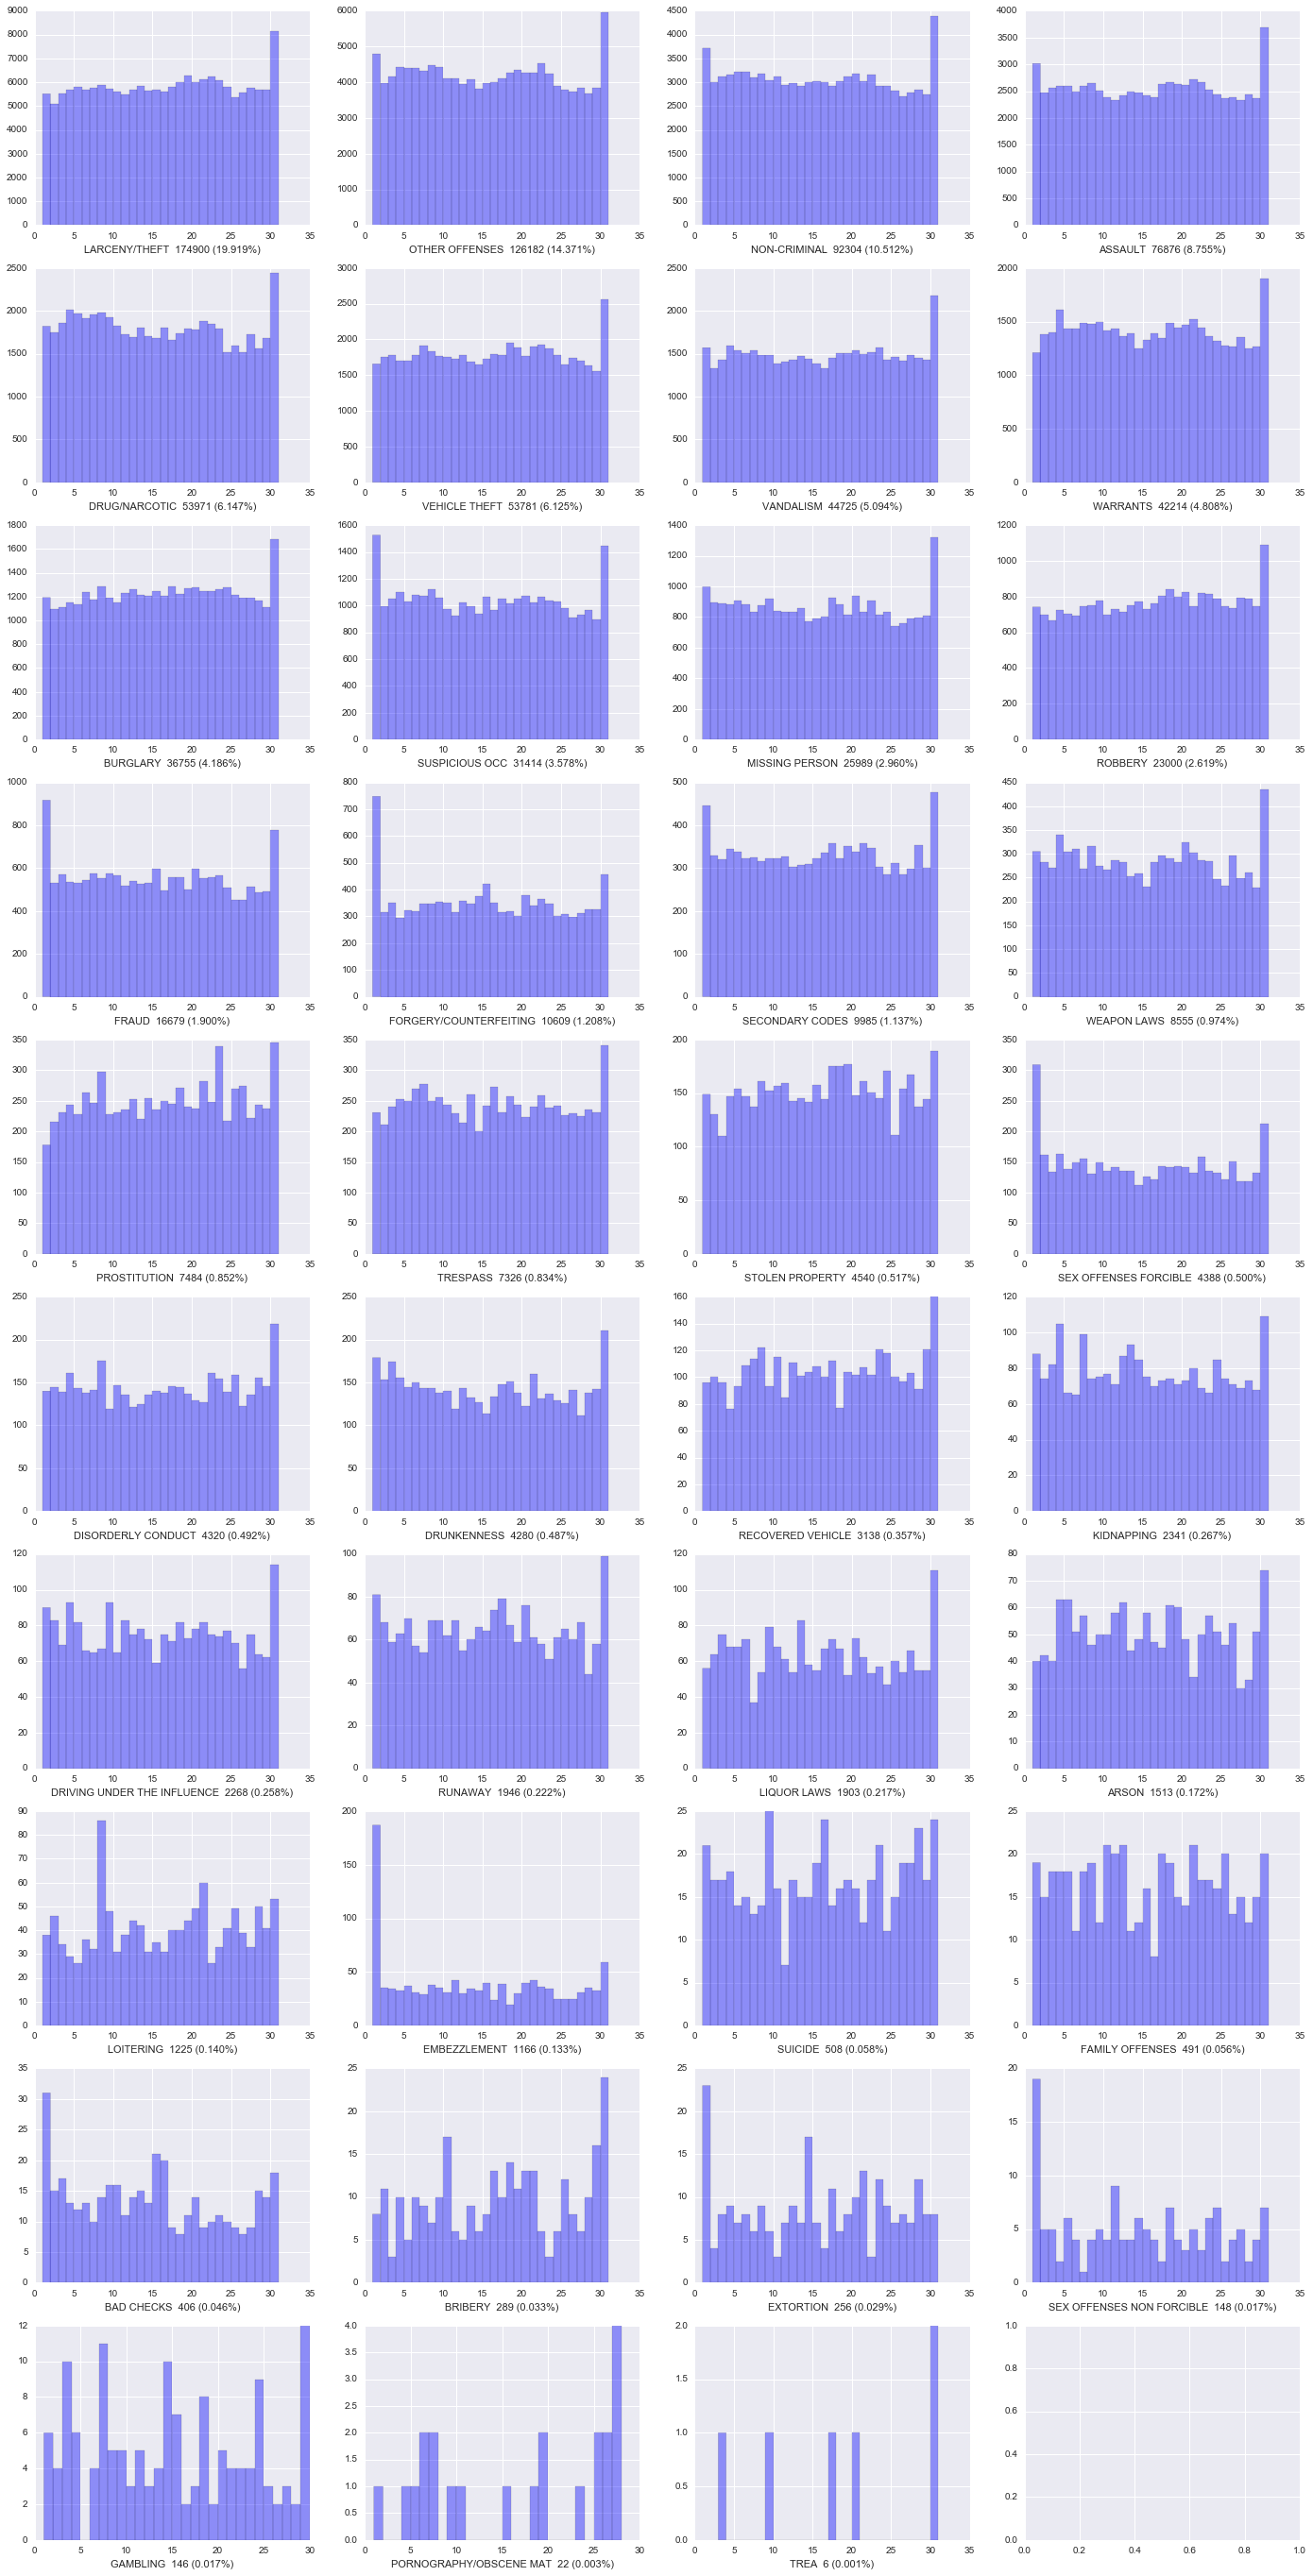

In [85]:
plot_by_category(data, "Dates-Day", color='b')

/Users/shaynekang/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


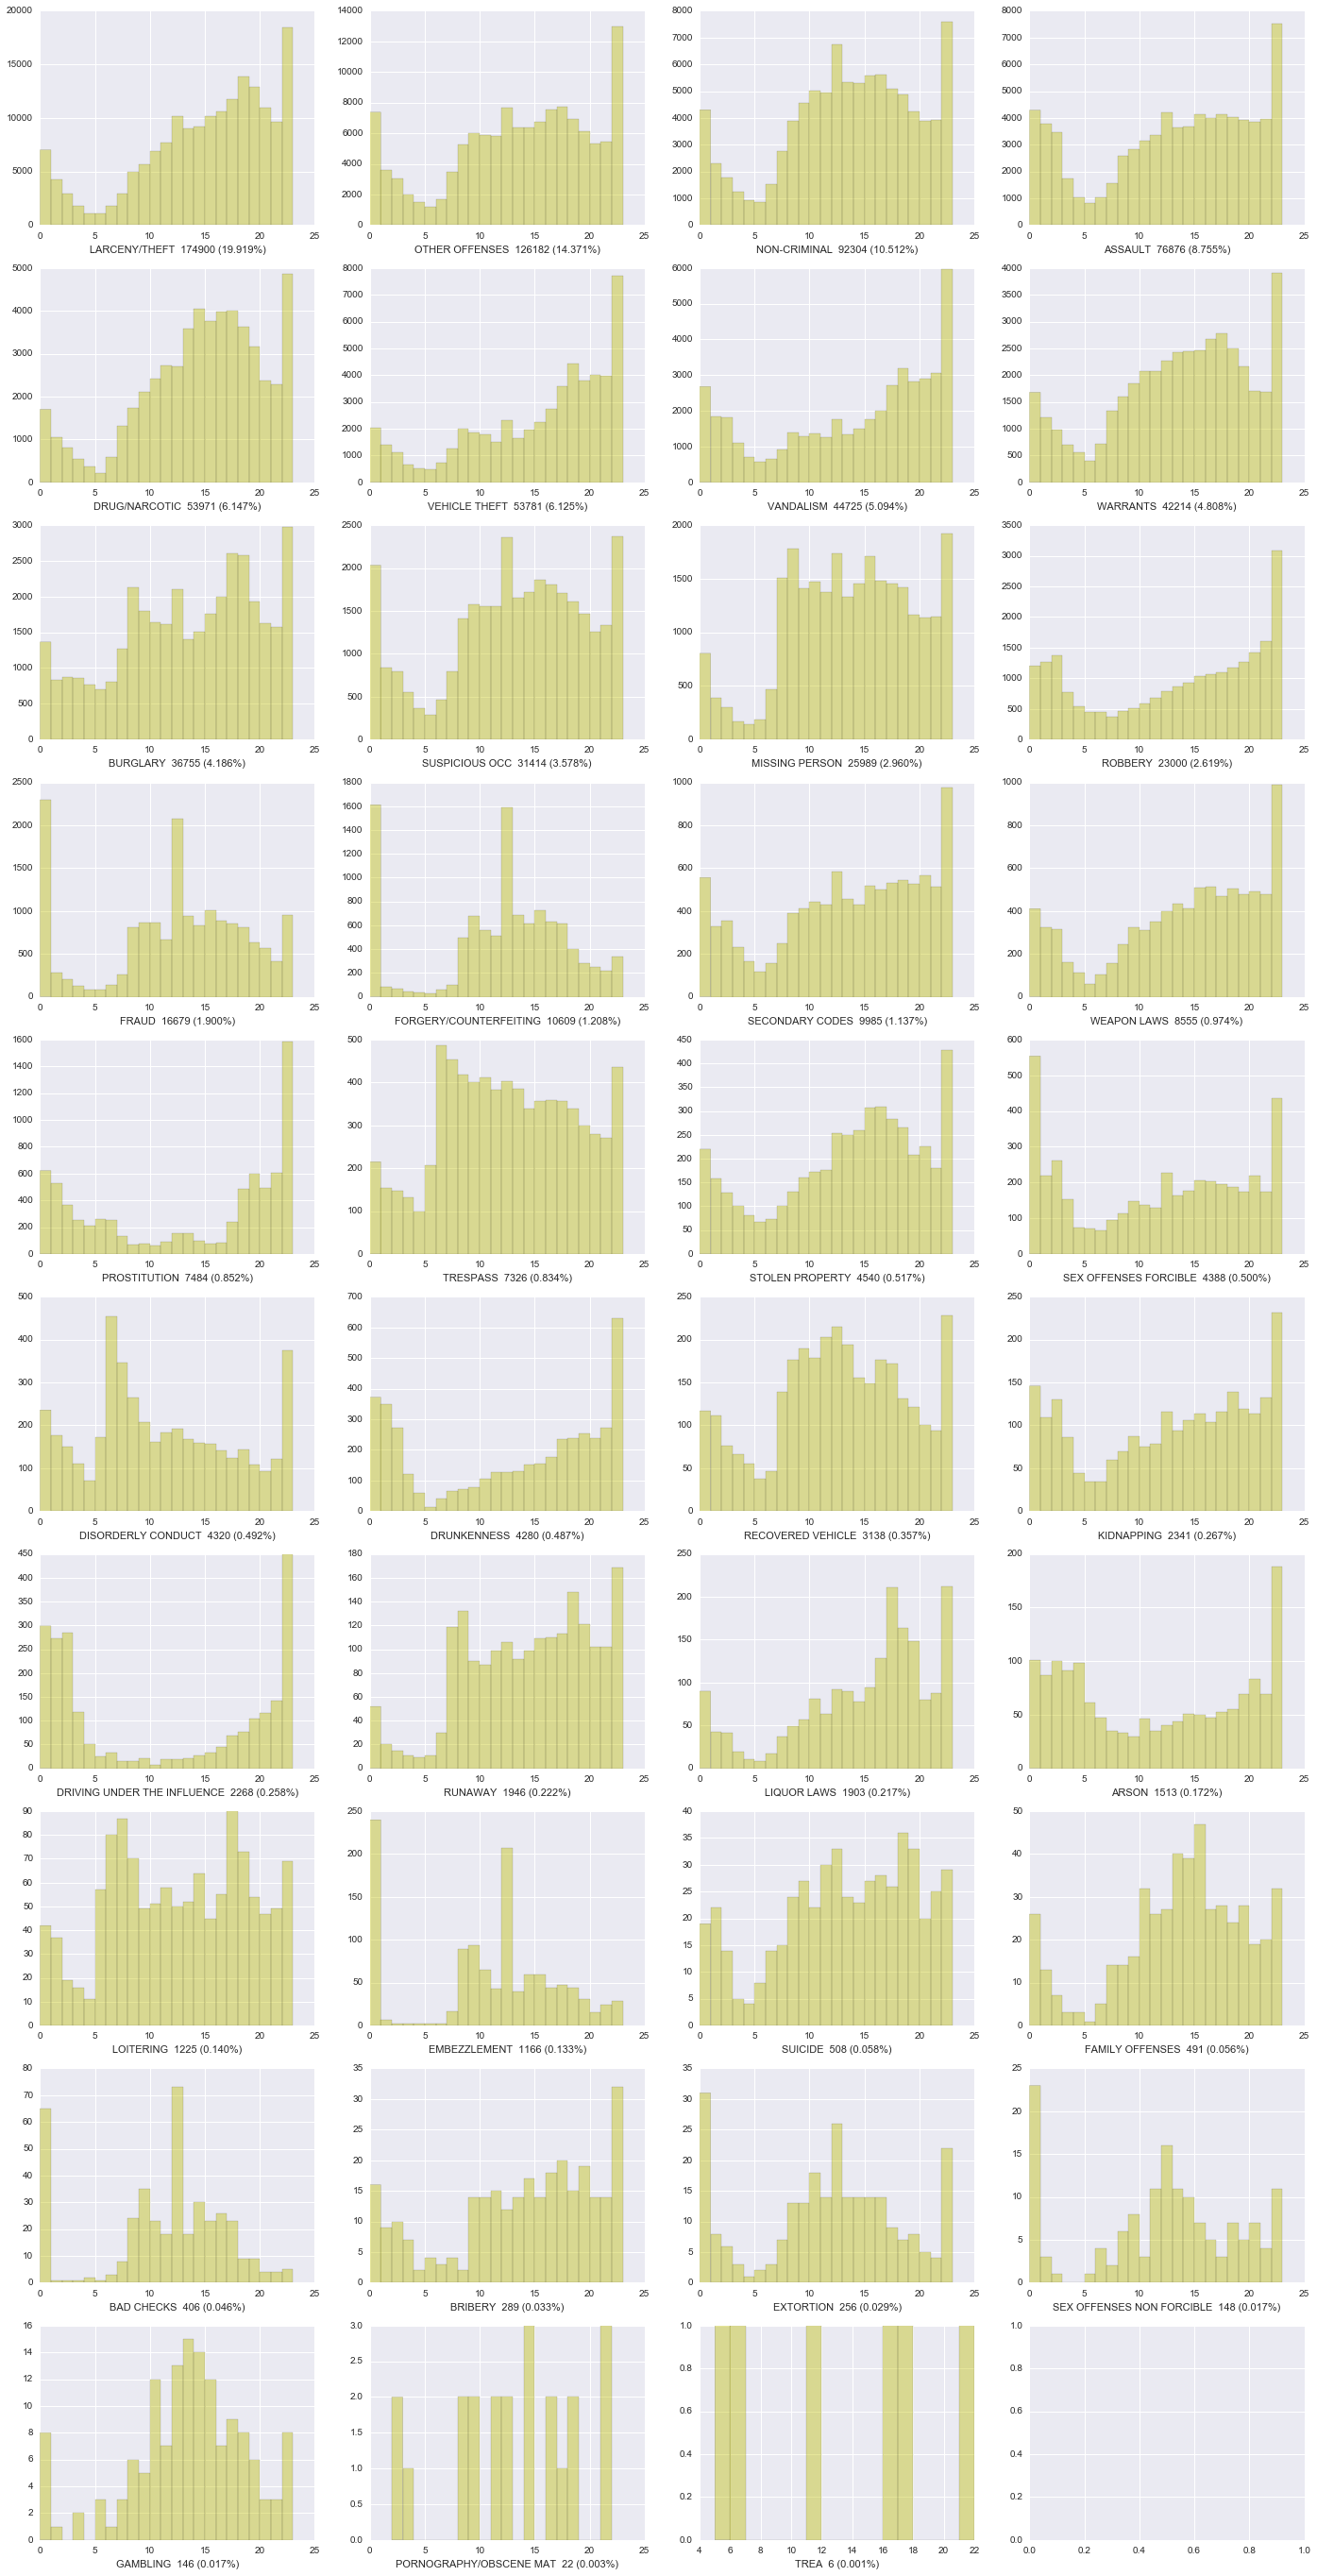

In [86]:
plot_by_category(data, "Dates-Hour", color='y')

/Users/shaynekang/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


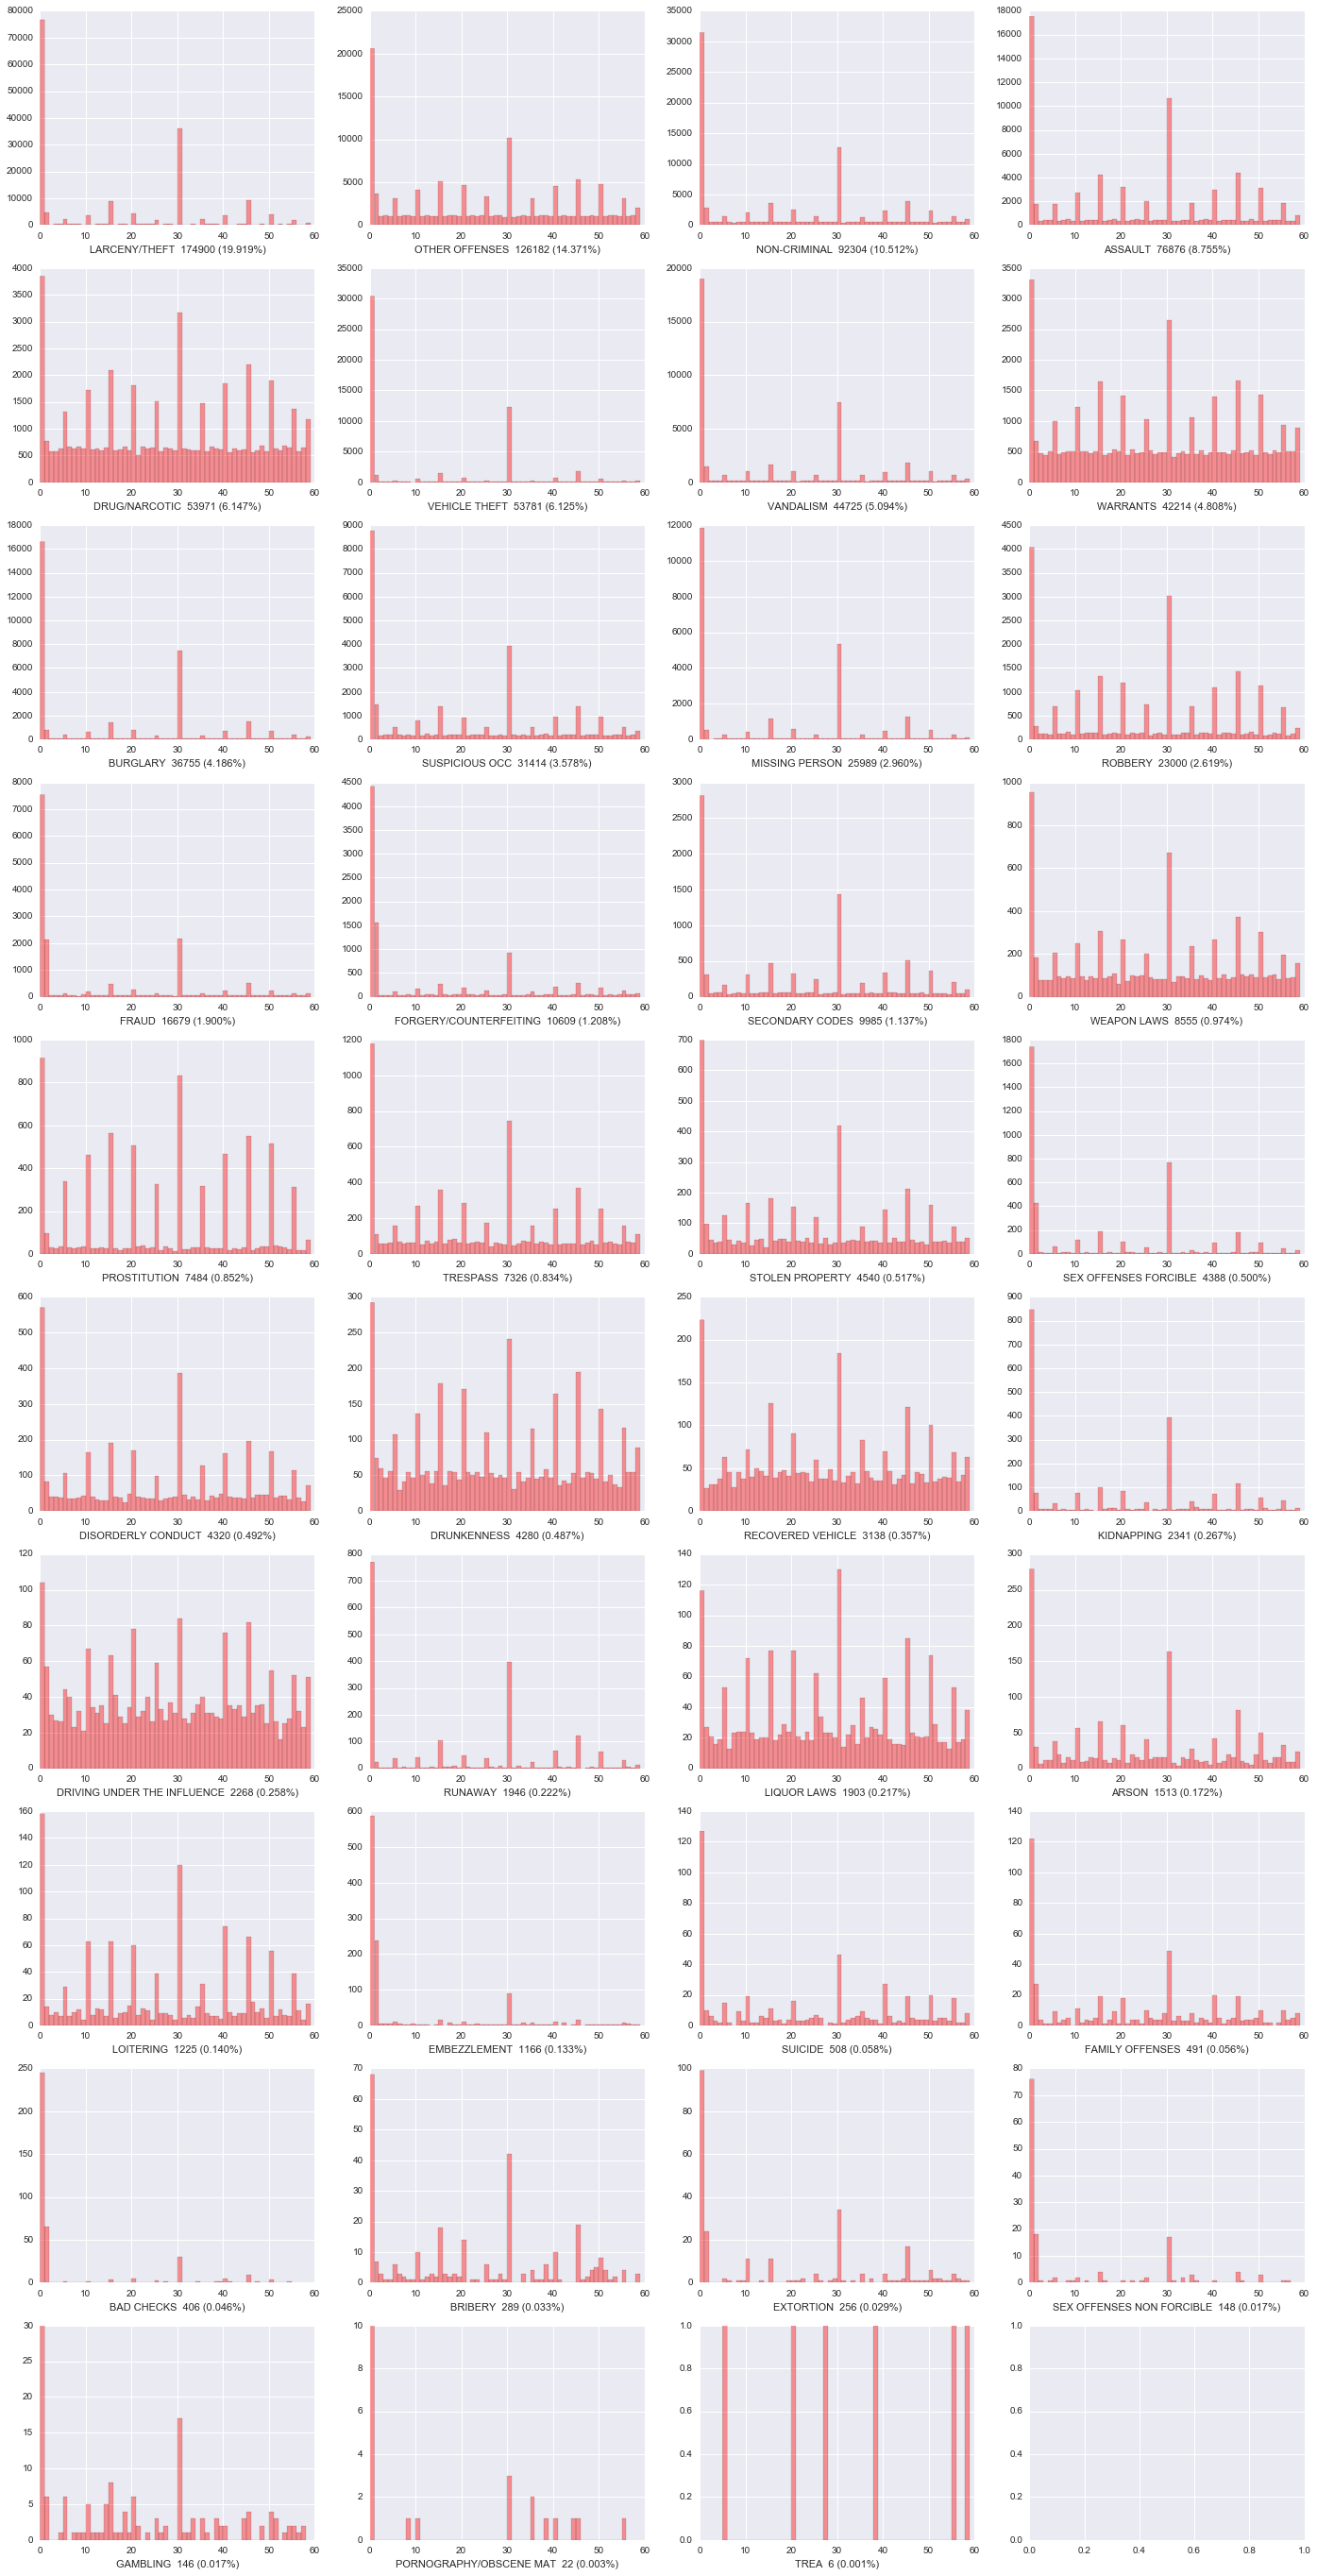

In [89]:
plot_by_category(data, "Dates-Minute", color='r')

## Observation

After the exploation, we have a suspicious that we can't trust some of the data. For example,
  * **Dates-Minute**: the distribution is biased to 0 and 30. this seems the problem of data aggregatation.
  * **Dates-Hour**: Biased to 0 and 24. Maybe same reason.
  * **Dates-Day**: Biased to 0, 30 and 31. Same reason.